Modelagem SARIMA

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import warnings as warning
warning.filterwarnings('ignore')
!pip install rpy2==3.5.0
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages('forecast', repos='https://cloud.r-project.org/')

(as ‘lib’ is unspecified)







	‘/tmp/RtmpgECg7P/downloaded_packages’



# Imports

In [ ]:
import pandas as pd
import rpy2.robjects as r
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot as plt
import rpy2.robjects as ro
from sklearn.preprocessing import StandardScaler


trainset=0.60
valset = 0.20

dimension=12

# Carga de dados

In [ ]:
base='/content/0+12 2025 - LatAm Business Analytics_No links.xlsx'
x=pd.read_excel(base)


# Tratamento de dados

Tratar colunas com espaços

In [ ]:
x.rename(columns=lambda x: x.strip(), inplace=True)

In [ ]:
x.columns

Index(['Type', 'YTD', 'Period', 'Year', 'Quarter', 'Month#', 'Month', 'Order',
       'Invoice', 'Customer', 'Customer Cluster', 'State', 'Country', 'Geo',
       'Region2', 'Region', 'Incoterm', 'RSM', 'REP', 'Business Unit',
       'Product Group', 'Product Line', 'Product', 'RTM/NRTM', 'Units',
       'Revenue USD', 'Commission USD', 'Other Revenue', 'Bookings',
       'Units (Dispenser)', 'FX', 'Aftermarket & Solutions', 'Booking date',
       'GM', 'EBIT', 'Revenue BRL', 'GM BRL', 'EBIT BRL', 'Brazil's Region',
       'Owner', 'Revenue Dispenser', 'Revenue Dispenser BRL', 'Cost Dispenser',
       'Cost Dispenser BRL', 'Base Model', 'Model String', 'EXW Process',
       'Ationet', 'Service Contract', 'Intercompany Type', 'Sales Campaing',
       'Expopostos', 'RTM', 'Aftermarket & Solutions type', 'Manager'],
      dtype='object')

Filtragem necessária para série

In [ ]:
x = x[x['Type'] == 'ACT'] # Somente faturados
x = x[x['Business Unit'] == 'Dispenser']  # Somente dispensers
x = x[x['Region2'] == 'Domestic']  # Somente região doméstica
x.shape

(19765, 55)

Tratamento de valores nulos

In [ ]:
x.dropna(subset=['Units', 'Commission USD'], inplace=True)

Regra de negócio para valores positivos

In [ ]:
x = x[x['Units'] > 0 ]  # Somente vendas
x.shape

(18446, 55)

Criação de uma coluna data para série

In [ ]:
x['Data'] = pd.to_datetime(x['Year'].astype(str) + '-' + x['Month#'].astype(str) + '-01')
x['Data'].unique()
x.columns

Index(['Type', 'YTD', 'Period', 'Year', 'Quarter', 'Month#', 'Month', 'Order',
       'Invoice', 'Customer', 'Customer Cluster', 'State', 'Country', 'Geo',
       'Region2', 'Region', 'Incoterm', 'RSM', 'REP', 'Business Unit',
       'Product Group', 'Product Line', 'Product', 'RTM/NRTM', 'Units',
       'Revenue USD', 'Commission USD', 'Other Revenue', 'Bookings',
       'Units (Dispenser)', 'FX', 'Aftermarket & Solutions', 'Booking date',
       'GM', 'EBIT', 'Revenue BRL', 'GM BRL', 'EBIT BRL', 'Brazil's Region',
       'Owner', 'Revenue Dispenser', 'Revenue Dispenser BRL', 'Cost Dispenser',
       'Cost Dispenser BRL', 'Base Model', 'Model String', 'EXW Process',
       'Ationet', 'Service Contract', 'Intercompany Type', 'Sales Campaing',
       'Expopostos', 'RTM', 'Aftermarket & Solutions type', 'Manager', 'Data'],
      dtype='object')

In [ ]:
x.columns

Index(['Type', 'YTD', 'Period', 'Year', 'Quarter', 'Month#', 'Month', 'Order',
       'Invoice', 'Customer', 'Customer Cluster', 'State', 'Country', 'Geo',
       'Region2', 'Region', 'Incoterm', 'RSM', 'REP', 'Business Unit',
       'Product Group', 'Product Line', 'Product', 'RTM/NRTM', 'Units',
       'Revenue USD', 'Commission USD', 'Other Revenue', 'Bookings',
       'Units (Dispenser)', 'FX', 'Aftermarket & Solutions', 'Booking date',
       'GM', 'EBIT', 'Revenue BRL', 'GM BRL', 'EBIT BRL', 'Brazil's Region',
       'Owner', 'Revenue Dispenser', 'Revenue Dispenser BRL', 'Cost Dispenser',
       'Cost Dispenser BRL', 'Base Model', 'Model String', 'EXW Process',
       'Ationet', 'Service Contract', 'Intercompany Type', 'Sales Campaing',
       'Expopostos', 'RTM', 'Aftermarket & Solutions type', 'Manager', 'Data'],
      dtype='object')

In [ ]:
print(x.isnull().sum())


Type                                0
YTD                                 0
Period                              0
Year                                0
Quarter                             0
Month#                              0
Month                               0
Order                               2
Invoice                             0
Customer                            0
Customer Cluster                    0
State                               0
Country                             0
Geo                                 0
Region2                             0
Region                              0
Incoterm                        11657
RSM                             11657
REP                             18446
Business Unit                       0
Product Group                       0
Product Line                        0
Product                             0
RTM/NRTM                         5909
Units                               0
Revenue USD                         0
Commission U

Identificação de campanha de vendas

In [ ]:
campanha = x['Sales Campaing'].unique()
print(campanha)

[nan 'CONV. VIBRA 2025' 'CONV. IPIRANGA 2025' 'Expopostos 2024'
 'Expopostos 2022' 'CONV. VIBRA' 'CONV. IPIRANGA' 'CONV. SHELL'
 'CAMPANHA JUN A SET' 'CAMPEÕES DO RTM' 'FELIZ BOMBA NOVA' 'RTM 2024'
 'CONV. VIBRA 2024' 'CONV. IPIRANGA 2024' 'CONV. RAIZEN 2024'
 'Nordeste 2024' 'RS 2024' 'Vista 2024' 'Campanha vibra 24'
 'FEIRAO DE FABRICA']


In [ ]:
# Dicionário de pesos das campanhas
pesos_campanhas = {
    'CONV. VIBRA 2025': 6,
    'CONV. IPIRANGA 2025': 6,
    'Expopostos 2024': 10,
    'Expopostos 2022': 10,
    'CONV. VIBRA': 6,
    'CONV. IPIRANGA': 6,
    'CONV. SHELL': 6,
    'CAMPANHA JUN A SET': 7,
    'CAMPEÕES DO RTM': 3,
    'FELIZ BOMBA NOVA': 3,
    'RTM 2024': 3,
    'CONV. VIBRA 2024': 6,
    'CONV. IPIRANGA 2024': 6,
    'CONV. RAIZEN 2024': 6,
    'Nordeste 2024': 4,
    'RS 2024': 4,
    'Vista 2024': 3,
    'Campanha vibra 24': 3,
    'FEIRAO DE FABRICA': 3,
    np.nan: 0.1
}


Criação de coluna de peso de campanha

In [ ]:
x['peso_campanha'] = x['Sales Campaing'].map(pesos_campanhas).fillna(0)

In [ ]:
x.columns

Index(['Type', 'YTD', 'Period', 'Year', 'Quarter', 'Month#', 'Month', 'Order',
       'Invoice', 'Customer', 'Customer Cluster', 'State', 'Country', 'Geo',
       'Region2', 'Region', 'Incoterm', 'RSM', 'REP', 'Business Unit',
       'Product Group', 'Product Line', 'Product', 'RTM/NRTM', 'Units',
       'Revenue USD', 'Commission USD', 'Other Revenue', 'Bookings',
       'Units (Dispenser)', 'FX', 'Aftermarket & Solutions', 'Booking date',
       'GM', 'EBIT', 'Revenue BRL', 'GM BRL', 'EBIT BRL', 'Brazil's Region',
       'Owner', 'Revenue Dispenser', 'Revenue Dispenser BRL', 'Cost Dispenser',
       'Cost Dispenser BRL', 'Base Model', 'Model String', 'EXW Process',
       'Ationet', 'Service Contract', 'Intercompany Type', 'Sales Campaing',
       'Expopostos', 'RTM', 'Aftermarket & Solutions type', 'Manager', 'Data',
       'peso_campanha'],
      dtype='object')

Agrupamento de variáveis target e exógenas

In [ ]:
x_grouped = x.groupby(pd.Grouper(key='Data', freq='MS')).agg({
    'Units': 'sum',
    'Commission USD': 'sum',
    'peso_campanha': 'sum'
}).reset_index()

In [ ]:
data = x_grouped['Units'].values

In [ ]:
print(data)

[389. 650. 501. 857. 643. 473. 564. 383. 845. 542. 635. 496. 451. 230.
 369. 400. 241. 174. 409. 454. 420. 225. 419. 208. 449. 858. 485. 306.
 351. 403. 345. 477. 331. 179. 166. 412. 367. 151. 322. 263. 224. 284.
 272. 287. 337. 471. 428. 352. 658. 318. 512. 267.  68. 124. 294. 456.
 463. 367. 386. 281. 342. 314. 344. 409. 302. 312. 261. 399. 352. 489.
 522. 442. 386. 323. 259. 277. 380.]


# Modelagem

In [ ]:
sarima_train=data[:np.int32(np.floor(trainset*(len(data))))]
sarima_val = data[len(sarima_train):len(sarima_train)+np.int32(np.floor(valset*(len(data))))]
sarima_test=data[len(sarima_train)+np.int32(np.floor(valset*(len(data)))):]

trainSize = len(sarima_train)
valSize = len(sarima_val)
testIndex=trainSize+valSize
dataSize=len(data)

#Funções da bibilioteca em R sendo armazenadas em variáveis
r.r('library(forecast)')
colnames=r.r('colnames')
arima = r.r('auto.arima')
arimaTest = r.r('Arima')
ordem = r.r('cbind')
fitted = r.r('fitted')
forecast = r.r('forecast')
arimaorder = r.r('arimaorder')
ts = r.r('ts')

exog_1 = x_grouped['Commission USD'].values
exog_2 = x_grouped['peso_campanha'].values

  method            from
  as.zoo.data.frame zoo 

  Want to stay up-to-date? Read the Hyndsight blog:
  https://robjhyndman.com/hyndsight/



In [ ]:
print(exog_1)

[ 37936.69013172  75985.01554534  55193.42470905  64269.7214251
  61143.0032564   61600.8862679   58846.3132641   85516.0918917
 110979.52780748 160147.07399552 140269.31939203 100864.67416949
  67418.9843084   48591.17425352  41576.12437155  25021.11769738
  69962.60340913  30282.47611624  24488.57826733  53138.9549909
  80490.50642244   9548.02438761  53342.9325635   35390.71708144
  56623.15783056  85176.41566567  66941.15078463  41949.21615832
  51134.56430837  60749.00422198  78838.81150067  93966.15991548
  79620.58313886  23508.8198339   22295.876094    94890.77995039
  43879.21896627  23621.80384611  17682.98067784  57031.49238821
  31270.36136494  50571.88403176  42469.27743356  22815.37740942
 108902.16337498  79955.18047282  95615.7423599   82599.54969894
 114205.         133541.         223755.          76722.
  53325.          24620.         151652.         168785.
 213819.         170411.         247379.          95436.
  58042.          98582.         122778.         183

In [ ]:
print(exog_2)

[  23.9   37.3   26.9   39.3   26.8   32.    37.5   22.8   58.7   35.9
   40.1   34.7   26.1   15.6   14.8   13.2   17.2   12.2   29.6   30.6
   26.6   13.4   17.3    8.1   24.8   28.4   24.3   21.2   23.8   20.4
   25.    31.8   22.8   13.1   11.9   28.8   24.5    9.9   22.    12.9
   17.7   18.6   17.7   18.6 1231.9 2140.3 1948.5  419.3   90.4   51.3
   31.3   37.3   24.   125.5  215.7  424.8 1005.2  985.1  526.7  270.
  379.5  411.1  365.8  486.8  270.2  185.6  242.8  321.1  264.  2133.3
 3063.1 1404.2  383.6  320.6  175.1  176.1  107.6]


In [ ]:
# Tratar variáveis constantes antes do scaler
if np.std(exog_1) == 0:
    exog_scaled_1 = np.zeros_like(exog_1)
else:
    exog_scaled_1 = StandardScaler().fit_transform(exog_1.reshape(-1,1)).flatten()

if np.std(exog_2) == 0:
    exog_scaled_2 = np.zeros_like(exog_2)
else:
    exog_scaled_2 = StandardScaler().fit_transform(exog_2.reshape(-1,1)).flatten()



In [ ]:
# Testar com variáveis logarítmicas
exog_log_1 = np.log(exog_1)
print(exog_log_1)

exog_log_2 = np.log(exog_2)
print(exog_log_2)

[10.543674   11.23829144 10.91859911 11.0708439  11.02097072 11.02843154
 10.98268446 11.35645985 11.61710103 11.98384788 11.85131956 11.52153504
 11.11868192 10.79119719 10.63528135 10.12747546 11.15571614 10.31832448
 10.10596209 10.88066555 11.29589452  9.16408954 10.88449677 10.47420484
 10.94417333 11.35247986 11.11156917 10.64421503 10.84221595 11.01450597
 11.27516069 11.45069    11.28502792 10.06513094 10.01215701 11.46048182
 10.68919611 10.06992546  9.78035791 10.95135889 10.35042601 10.83115105
 10.65653621 10.03519004 11.59820517 11.28922151 11.46809275 11.32175951
 11.64575036 11.80216383 12.31830698 11.24794378 10.88416054 10.1113144
 11.9293437  12.03638099 12.27288514 12.04596845 12.41867685 11.46621114
 10.96892217 11.49864397 11.71813313 12.11747091 11.52936952 11.38012523
 11.71030803 11.78651875 11.44965547 12.15791128 12.42580238 12.04305359
 11.86937538 11.37377833 11.76013704 11.23630202 11.67432977]
[3.17387846 3.61899333 3.29212629 3.67122452 3.28840189 3.46573

Código com possibilidade de teste para duas variáveis exógenas - logaritmicas ou scalar

In [ ]:
# organizar as variáveis exógenas em um listvector do R

xreg=ordem(exog_log_1[:trainSize],exog_2[:trainSize])

xregVal=ordem(exog_log_1[trainSize:testIndex],exog_2[trainSize:testIndex])

xregTest=ordem(exog_log_1[testIndex:],exog_2[testIndex:])

# treinar o modelo arima, passando como argumento as variáveis exógenas
mdl_arimax_treino = arima(np.array(sarima_train),xreg=xreg)
fit_Arimax_Val = arimaTest(np.array(sarima_val),xreg=xregVal,model=mdl_arimax_treino)
fit_Arimax_Test = arimaTest(np.array(sarima_test),xreg=xregTest,model=mdl_arimax_treino)


# Informar ao modelo que é uma série sazonal com frequencia 12
sarimax_train = ts(np.array(sarima_train),frequency=dimension)
sarimax_val = ts(np.array(sarima_val),frequency=dimension)
sarimax_test = ts(np.array(sarima_test),frequency=dimension)

trainSize = len(sarima_train)
valSize = len(sarima_val)
testIndex=trainSize+valSize
dataSize=len(data)

#O modelo SARIMA, pode produzir um modelo ARIMA.

mdl_sarima = arima(sarima_train, xreg=xreg)

In [ ]:
mdl_sarima_auto = arima(sarima_train, seasonal=True, stepwise=True, approximation=False)
print(arimaorder(mdl_sarima_auto))  # Isso te dá [p,d,q,P,D,Q]

[0 1 1]


Teste com parametros manuais

In [ ]:

# Ajuste manual dos parametros p, d, q P, D, Q
mdl_sarima = arimaTest(
    sarima_train,
    xreg=xreg,
    order=ro.IntVector([4, 1, 4]),  # ARIMA(p,d,q)
    seasonal=ro.ListVector({
        'order': ro.IntVector([1, 1, 2]),  # SARIMA(P,D,Q)
        'period': ro.IntVector([dimension])  # período sazonal
    }),
    method="ML"
)

In [ ]:
len(mdl_sarima)

19

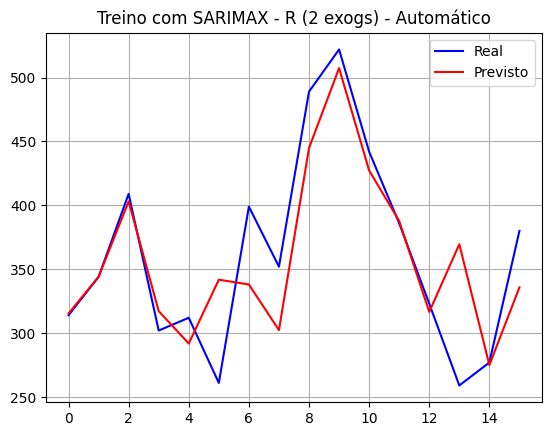

In [ ]:
# Ober as previsões de um passo à frente com o ARIMA
fitTreinoSarimax = arimaTest(sarima_train,xreg=xreg,model=mdl_sarima)
fitValidSarimax = arimaTest(sarima_val,xreg=xregVal,model=mdl_sarima)
fitTesteSarimax = arimaTest(sarima_test,xreg=xregTest,model=mdl_sarima)

predSarimaxTreino = fitted(fitTreinoSarimax)
predSarimaxVal = fitted(fitValidSarimax)
predSarimaxTest = fitted(fitTesteSarimax)

#plt.figure(figsize=(12, 6))
plt.plot(sarimax_test, color='blue')
plt.plot(predSarimaxTest, color='red')
plt.legend(['Real', 'Previsto'])
plt.grid(True)
plt.title('Treino com SARIMAX - R (2 exogs) - Automático')
plt.show()



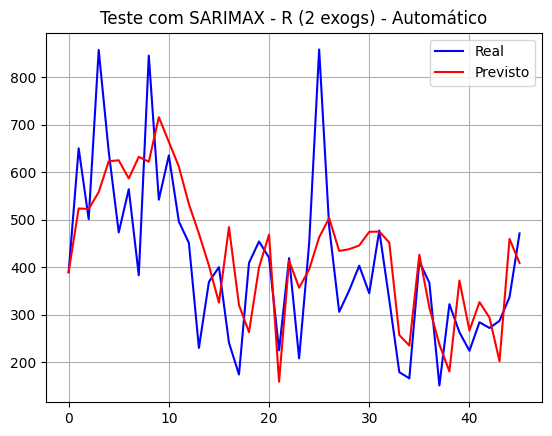

In [ ]:
# Ober as previsões de um passo à frente com o ARIMA
fitTreinoSarimax = arimaTest(sarima_train,xreg=xreg,model=mdl_sarima)
fitValidSarimax = arimaTest(sarima_val,xreg=xregVal,model=mdl_sarima)
fitTesteSarimax = arimaTest(sarima_test,xreg=xregTest,model=mdl_sarima)

predSarimaxTreino = fitted(fitTreinoSarimax)
predSarimaxVal = fitted(fitValidSarimax)
predSarimaxTest = fitted(fitTesteSarimax)


plt.plot(sarimax_train, color='blue')
plt.plot(predSarimaxTreino, color = 'red')
plt.legend(['Real','Previsto'])
plt.title('Teste com SARIMAX - R (2 exogs) - Automático')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
import pandas as pd

# ----------------- Cálculo dos erros -----------------

# VALIDAÇÃO
mseValSarima = mse(sarimax_val, predSarimaxVal)
maeValSarima = mae(sarimax_val, predSarimaxVal)
rmseValSarima = np.sqrt(mseValSarima)
mapeValSarima = mape(sarimax_val, predSarimaxVal) * 100

# TESTE
mseTestSarima = mse(sarimax_test, predSarimaxTest)
maeTestSarima = mae(sarimax_test, predSarimaxTest)
rmseTestSarima = np.sqrt(mseTestSarima)
mapeTestSarima = mape(sarimax_test, predSarimaxTest) * 100

# ----------------- Organização dos resultados -----------------

my_results = pd.DataFrame({
    'MSE': [mseValSarima, mseTestSarima],
    'RMSE': [rmseValSarima, rmseTestSarima],
    'MAE': [maeValSarima, maeTestSarima],
    'MAPE': [mapeValSarima, mapeTestSarima]
}, index=['Validação', 'Teste'])

# ----------------- Formatação amigável -----------------

my_results_formatted = my_results.copy()
my_results_formatted['MSE'] = my_results['MSE'].apply(lambda x: f"{x:,.2f}")
my_results_formatted['RMSE'] = my_results['RMSE'].apply(lambda x: f"{x:,.2f}")
my_results_formatted['MAE'] = my_results['MAE'].apply(lambda x: f"{x:,.2f}")
my_results_formatted['MAPE'] = my_results['MAPE'].apply(lambda x: f"{x:.2f}%")

# ----------------- Exibição -----------------

print(my_results_formatted)


                 MSE    RMSE    MAE    MAPE
Validação  12,359.71  111.17  82.80  41.36%
Teste       1,873.97   43.29  29.53   9.15%


In [ ]:
media = np.mean(exog_scaled_1[-19:])
print("Média dos últimos 19 exog:", media)
print("Últimos valores do target (sarima_train):", sarima_train[-3:])


Média dos últimos 19 exog: 0.7967731194121567
Últimos valores do target (sarima_train): [287. 337. 471.]


Previsão com h passos à frente

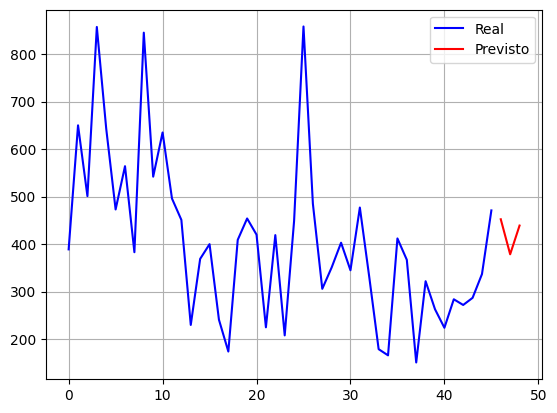

In [ ]:
# Supondo exog_1 e exog_2 com dados futuros alinhados
exog_1_futuro = exog_log_1[-3:]
exog_2_futuro = exog_2[-3:]

# Combina as duas colunas no padrão do R
xreg_futuro = ordem(exog_1_futuro, exog_2_futuro)

# Faz a previsão
forecast_ahead = forecast(mdl_sarima, h=3, xreg=xreg_futuro)
preds_ahead = np.array(forecast_ahead[3], dtype=float)

plt.plot(range(0,len(sarimax_train)),sarimax_train, color='blue')
plt.plot(range(len(sarimax_train),len(sarimax_train)+3),preds_ahead, color='red')
plt.legend(['Real','Previsto'])
plt.grid(True)
plt.show()

In [ ]:
print('Previsão (preds_ahead)', [f'{abs(int(x))}' for x in preds_ahead])

Previsão (preds_ahead) ['452', '378', '439']
